In [390]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import networkx as nx
import scipy as si
from sklearn import tree, linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [5]:
# merge puma codes with sub-bourough data
puma_cd_name = pd.read_csv('../data/PUMA_CD_NAME.csv',index_col = 0)
median_rents = pd.read_csv('../data/sub-borougharea-medianrentall2016.csv')
median_rents = median_rents.merge(puma_cd_name, left_on = 'Sub-Borough Area', right_on = 'CD_Name', how = 'outer')
median_rents = median_rents.set_index('puma')
median_incomes = pd.read_csv('../data/sub-borougharea-medianhouseholdincome2016.csv')
median_incomes = median_incomes.merge(puma_cd_name, left_on = 'Sub-Borough Area', right_on = 'CD_Name', how = 'outer')
median_incomes = median_incomes.set_index('puma')
education_levels = pd.read_csv('../data/sub-borougharea-populationaged25withabachelorsdegreeorhigher.csv')
education_levels = education_levels.merge(puma_cd_name, left_on = 'Sub-Borough Area', right_on = 'CD_Name', how = 'outer')
education_levels = education_levels.set_index('puma')
percents_white = pd.read_csv('../data/sub-borougharea-percentwhite.csv')
percents_white = percents_white.merge(puma_cd_name, left_on = 'Sub-Borough Area', right_on = 'CD_Name', how = 'outer')
percents_white = percents_white.set_index('puma')
nyc_median_incomes = pd.read_csv('../data/city-medianhouseholdincome2016.csv')
nyc_median_rents = pd.read_csv('../data/city-medianrentall2016.csv')

In [6]:
median_rents.head()

,short_name,long_name,Sub-Borough Area,2000,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,cd,CD_Name
puma,,,,,,,,,,,,,,,,,,
4109,gross_rent_adj,"Median rent, all ($2016)",Sunnyside/Woodside,1130,1280,1270,1340,1280,1360,1410,1430,1460,1460,1570,1600,1570,QN02,Sunnyside/Woodside
3810,gross_rent_adj,"Median rent, all ($2016)",Greenwich Village/Financial District,1680,2010,2100,2160,2180,990,1530,1280,1360,1520,1300,2680,2530,MN01MN02,Greenwich Village/Financial District
3708,gross_rent_adj,"Median rent, all ($2016)",Highbridge/South Concourse,870,930,950,990,1000,1000,1040,1040,1030,1110,1060,1100,1110,BX04,Highbridge/South Concourse
3903,gross_rent_adj,"Median rent, all ($2016)",North Shore,1010,1150,1130,1210,1200,1130,1240,1160,1120,1100,1130,1180,1220,SI01,North Shore
3710,gross_rent_adj,"Median rent, all ($2016)",Mott Haven/Hunts Point,550,630,730,720,740,780,770,770,780,850,830,860,950,BX01BX02,Mott Haven/Hunts Point


In [7]:
income_diffs = pd.DataFrame(index = median_incomes.index, columns=['Sub-Borough Area'])
income_diffs['Sub-Borough Area'] = median_incomes['Sub-Borough Area']
income_diffs['2005'] = median_incomes['2005'] - nyc_median_incomes['2005'][0]
low_income = income_diffs['2005'] < income_diffs['2005'].quantile(q=0.4)
income_diffs[low_income]['Sub-Borough Area']

puma
3709                   Soundview/Parkchester
3801               Washington Heights/Inwood
4014                            Borough Park
3708              Highbridge/South Concourse
3803                          Central Harlem
4101                                 Astoria
4015                                Flatbush
3705                      Morrisania/Belmont
4008             East New York/Starrett City
4006    North Crown Heights/Prospect Heights
3802    Morningside Heights/Hamilton Heights
4001                 Williamsburg/Greenpoint
3707              University Heights/Fordham
3706             Kingsbridge Heights/Moshulu
3710                  Mott Haven/Hunts Point
3809               Lower East Side/Chinatown
3804                             East Harlem
4007                  Brownsville/Ocean Hill
4011                     South Crown Heights
4018                            Coney Island
4003                      Bedford Stuyvesant
4002                                Bushwick
Name:

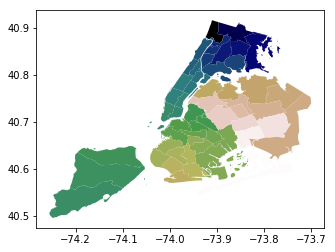

In [8]:
sbas = gpd.read_file('../data/Public Use Microdata Areas (PUMA)/')
sbas['puma'] = sbas['puma'].astype('int64')
sbas.plot(cmap='gist_earth')
plt.show()

In [9]:
sbas = sbas.merge(puma_cd_name, on='puma')

In [10]:
puma_cd = pd.read_csv('../data/PUMA_CD_NAME.csv')
puma_cd['cd'] = puma_cd['cd'].str.replace(" ", "")
sbas['cd'] = sbas['cd'].str.replace(" ","")

In [11]:
G = nx.Graph()
G.add_nodes_from(sbas.index)
n = len(sbas.index)
for i,row in sbas.iterrows():
    for j in range(i+1,n):
        if row['geometry'].touches(sbas.loc[j]['geometry']):
            dist = row['geometry'].centroid.distance(sbas.loc[j]['geometry'].centroid) 
            G.add_edge(i,j, weight=dist)

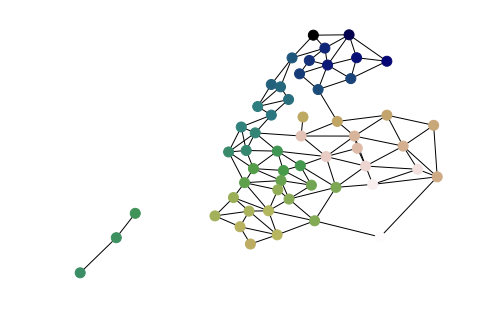

In [12]:
nx.draw(G, pos = sbas['geometry'].centroid.map(lambda p: (p.x,p.y)).to_dict(), node_size=100, node_color=range(n), cmap=plt.cm.gist_earth)
plt.show()

In [13]:
years = ['2000'] + [str(y) for y in range(2005,2017)]
columns = ['cd'] + years
# neighbor_mean = np.zeros(len(sbas.index), len(years))
# moransi = np.zeros(len(sbas.index), len(years))
mean_rents = median_rents.mean()
neighbor_means = pd.DataFrame()
for v in G.nodes():
    puma = sbas.iloc[v]['puma']
    neighbors = G[v].keys()
    neighbor_cds = list(sbas.iloc[neighbors]['cd'])
    rent_rows = median_rents[median_rents['cd'].isin(neighbor_cds)][columns]
    mean_row = rent_rows.mean()
    mean_row['puma'] = puma
    neighbor_means = neighbor_means.append(mean_row, ignore_index=True)

In [14]:
neighbor_means['puma'] = neighbor_means['puma'].astype('int64')
neighbor_means = neighbor_means.merge(puma_cd_name, on = 'puma')
neighbor_means = neighbor_means.set_index('puma')

In [15]:
# wmatrix = pysal.weights.WSP(nx.adj_matrix(G))

In [16]:
subways = pd.read_csv('../data/communitydistrict-residentialunitswithin12mileofasubwaystation.csv')

In [17]:
subways['cd'], subways['CD_Name'] = subways['Community District'].str.split(" - ",1).str
subways['cd'] = subways['cd'].str.replace(" ", "")

In [18]:
# # Merge community district data into PUMAs based on 2010 census
housing_units = pd.read_csv('../data/community_district_housing_units2010.csv')
housing_units['cd'] = housing_units['Community_District'].str.lstrip()
housing_units['cd'] = housing_units['cd'].str.rstrip()
housing_units['Borough'], housing_units['CD_Number'] = housing_units['cd'].str.split(" ",1).str
housing_units['CD_Number']= housing_units['CD_Number'].str.zfill(2)
housing_units['cd'] = housing_units['Borough'] + housing_units['CD_Number']
housing_units = housing_units[['cd', 'Units']]
housing_units['Units'] = housing_units['Units'].str.replace(',','').astype('int64')

In [19]:
population = pd.read_csv('../data/community_district_population2010.csv')
population['cd'] = population['Community_District'].str.lstrip()
population['cd'] = population['cd'].str.rstrip()
population['Borough'], population['CD_Number'] = population['cd'].str.split(" ",1).str
population['CD_Number']= population['CD_Number'].str.zfill(2)
population['cd'] = population['Borough'] + population['CD_Number']
population = population[['cd', 'Population']]

In [20]:
merging = [('BX01', 'BX02'), ('BX03', 'BX06'), ('MN01', 'MN02'), ('MN04', 'MN05')]
subways = subways[['cd', '2016']]
merged = []
for i,(a,b) in enumerate(merging):
    u = float(housing_units[housing_units['cd']==a]['Units'].values[0])
    v = float(housing_units[housing_units['cd']==b]['Units'].values[0])
    denom = u + v
    newval = u *subways[subways['cd']==a]['2016'].values[0] + v * subways[subways['cd']==b]['2016'].values[0]
    newval = newval / float(denom)
    merged.append({
        'cd': a + b, 
        '2016': newval})
subways = subways.append(merged, ignore_index = True)

In [21]:
subways = subways.merge(puma_cd_name, on = 'cd', how = 'outer')

In [22]:
subways = subways.dropna(how='any')

In [23]:
subways = subways.set_index('puma')

In [24]:
new_units = pd.read_csv('../data/communitydistrict-unitsauthorizedbynewresidentialbuildingpermits.csv')
new_units['cd'], new_units['Name'] = new_units['Community District'].str.split(" - ",1).str
new_units['cd'] = new_units['cd'].str.replace(' ','')
years = [str(n) for n in range(2000,2017)]
indices = ['cd', 'Name'] + years
new_units = new_units[indices]
for i,(a,b) in enumerate(merging):
    u = float(housing_units[housing_units['cd']==a]['Units'].values[0])
    v = float(housing_units[housing_units['cd']==b]['Units'].values[0])
    denom = u + v
    row1 = new_units[new_units['cd']==a][years].values
    row2 = new_units[new_units['cd']==b][years].values
    newvals = (u * row1 + v * row2) / denom
    newrow = new_units[new_units['cd']==a].copy()
    newrow = pd.DataFrame(newvals, columns=years) 
    newrow['cd'] = a + b
    new_units = new_units.append(newrow, ignore_index = True)

In [25]:
new_units = new_units.merge(puma_cd_name, on='cd', how='outer')
new_units = new_units[pd.notnull(new_units['CD_Name'])]
new_units['puma'] = new_units['puma'].astype('int64')
new_units = new_units.set_index('puma')

In [26]:
crime = pd.read_csv('../data/communitydistrict-seriouscrimerateper1000residents.csv')
crime['cd'], crime['CD_Name'] = crime['Community District'].str.split(" - ",1).str
crime['cd'] = crime['cd'].str.replace(' ','')
years = [str(n) for n in range(2006,2017)]
indices = ['cd'] + years
crime = crime[indices]
for i,(a,b) in enumerate(merging):
    u = float(population[population['cd']==a]['Population'].values[0])
    v = float(population[population['cd']==b]['Population'].values[0])
    denom = u + v
    row1 = crime[crime['cd']==a][years].values
    row2 = crime[crime['cd']==b][years].values
    newvals = (u * row1 + v * row2) / denom
    newrow = new_units[new_units['cd']==a].copy()
    newrow = pd.DataFrame(newvals, columns=years) 
    newrow['cd'] = a + b
    crime = crime.append(newrow, ignore_index = True)

In [27]:
crime = crime.merge(puma_cd_name, on='cd', how='outer')
crime = crime[pd.notnull(crime['CD_Name'])]
crime['puma'] = crime['puma'].astype('int64')
crime = crime.set_index('puma')

In [28]:
years = [str(y) for y in range(2005,2017)]
subways = pd.concat([subways['2016']]*12, axis=1)
subways.columns = years

In [29]:
# horrendous and lazy way to fill in missing values
lineup = crime['2006'].values
crime.insert(0, '2005', lineup)

In [30]:
median_incomes = median_incomes.sort_index()
education_levels = education_levels.sort_index()
percents_white = percents_white.sort_index()
percents_white[years] = percents_white[years].interpolate(method='linear', axis = 0)
subways = subways.sort_index()
new_units[years] = new_units[years].interpolate(method='linear', axis = 0)
new_units = new_units.sort_index()
crime = crime.sort_index()
neighbor_means = neighbor_means.sort_index()
median_rents = median_rents.sort_index()

In [31]:
n = 11 # number of years
m = 7 # number of features
k = 55 # number of PUMAs
# Stack our observations: first axis is PUMA, second is year, third is feature
Xs = np.dstack([median_incomes[years].values, 
                     education_levels[years].values, 
                     percents_white[years].values, 
                     subways[years].values, 
                     new_units[years].values, 
                     crime[years].values, 
                     neighbor_means[years].values, 
                     median_rents[years].ewm(com=2).mean().values])

# Observations
Y = median_rents[years].astype('float32').values
X_test = Xs[:,-1,:]
Y_test = Y[:,-1]
Y = Y[:,:-1]
X = Xs[:, :-1, :]
clf = tree.DecisionTreeRegressor()
predictions = np.zeros(k)
resids = np.zeros(k)
for i in range(k):
    clf = clf.fit(X[i], Y[i])
    predictions[i] = clf.predict(X_test[i,:].reshape(1, -1))

In [32]:
sns.set_style('whitegrid')
N = 55
fig, ax = plt.subplots()
width = 0.35
ind = np.arange(N)
p1 = ax.plot(errs, 'o-')
ax.set_title('Rents Actual vs Predicted')
ax.set_xticks(ind + width / 2)
errs = predictions - Y_test
ax.set_title('Decision Tree Prediction Error')
ax.set_xticklabels(median_rents['Sub-Borough Area'], rotation='vertical', fontsize = 5)
plt.ylabel('Error (Dollars/Month)')
plt.show()

NameError: name 'errs' is not defined

In [92]:
sns.set_style("whitegrid")
N = 55
fig, ax = plt.subplots()
width = 0.35
ind = np.arange(N)
p1 = ax.bar(ind, Y_test, width, bottom=0)
p2 = ax.bar(ind + width, predictions, width, bottom=0)
ax.set_title('Rents Actual vs Decision Tree Predictions')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(median_rents['Sub-Borough Area'], rotation='vertical', fontsize = 5)
ax.legend((p1[0], p2[0]), ('Actual', 'Predicted'))
plt.ylabel("Monthly Rent (Dollars)")
plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape

In [165]:
n = 12 # number of years
m = 6 # number of features
k = 55 # number of PUMAs

features = [median_incomes[years].values, education_levels[years].values, percents_white[years].values, subways[years].values, new_units[years].values, crime[years].values]

# Normalize features
for i in range(len(features)):
    features[i] = features[i] - np.repeat(np.mean(features[i], axis = 1).reshape(k,1), n, axis = 1)
    features[i] = normalize(features[i])

Xs = np.dstack(features)
    
# Normalize Observations
Y = median_rents[years].astype('float32').values
Y = Y - np.repeat(np.mean(Y, axis = 1).reshape(k,1), n, axis = 1)
Y = np.divide(Y, np.linalg.norm(Y, axis = 1).reshape(k,1))
X_test = Xs[:,-2:,:]
Y_test = Y[:,-2:]
Y = Y[:,:-2]
X = Xs[:, :-2, :]
clf = linear_model.LinearRegression()
predictions = np.zeros((k,2))
rvals = np.zeros(k)
mses = np.zeros(k)
residslin2 = np.zeros(k)
for i in range(k):
    clf = clf.fit(X[i], Y[i])
    predictions[i,:] = clf.predict(X_test[i,:])
    rvals[i] = clf.score(X[i], Y[i])
    mses[i] = mean_squared_error(Y[i], clf.predict(X[i]))
    residslin1[i] = Y_test[i,1] - clf.predict(X_test[i,1].reshape(1, -1))

In [265]:
n = 12 # number of years
m = 8 # number of features
k = 55 # number of PUMAs

features = [median_incomes[years].values, education_levels[years].values, percents_white[years].values, subways[years].values, new_units[years].values, crime[years].values, neighbor_means[years].values, median_rents[years].ewm(com=2).mean().values]
feature_labels = ['median_incomes', 'education_level', 'percent_white', 'subways', 'new_units', 'crime', 'spatial_lag','emw']

# Normalize features
for i in range(len(features)):
    features[i] = features[i] - np.repeat(np.mean(features[i], axis = 1).reshape(k,1), n, axis = 1)
    features[i] = normalize(features[i])

X = np.dstack(features)    
    
Y = median_rents[years].astype('float32').values
Y = Y - np.repeat(np.mean(Y, axis = 1).reshape(k,1), n, axis = 1)
Y = np.divide(Y, np.linalg.norm(Y, axis = 1).reshape(k,1))

X_test = Xs[:,-2:,:]
Y_test = Y[:,-2:]
Y_train = Y[:,:-2]
X_train = Xs[:, :-2, :]

In [241]:
pcas = np.zeros((k,m,m))
expratios = np.zeros((k,m))
pca = PCA()
for i in range(k):
    pca = pca.fit(X_train[i], Y_train[i])
    pcas[i] = pca.components_
    expratios[i] = pca.explained_variance_ratio_

In [287]:
pcsbyneighborhood = pd.DataFrame(pcas[1], columns = feature_labels).transpose()
pcsbyneighborhood

,0,1,2,3,4,5,6,7
median_incomes,5.094294e-01,-2.009475e-01,-5.056150e-01,2.392221e-01,-2.810756e-01,4.240430e-01,-3.583464e-01,-0.000000e+00
education_level,-3.643073e-01,2.322071e-01,-7.748932e-01,-3.872326e-01,2.491922e-01,-1.421296e-02,-2.555054e-02,-2.147513e-17
percent_white,1.440539e-01,1.015659e-01,-2.816207e-01,7.211378e-01,3.607389e-01,-4.280326e-01,2.371463e-01,-2.174781e-16
subways,-5.162258e-33,1.062043e-32,1.387779e-17,-3.763625e-32,-5.551115e-17,6.661338e-16,7.216450e-16,-1.000000e+00
new_units,2.911884e-01,8.776876e-01,3.501245e-02,-4.795664e-02,-3.626449e-01,-9.887235e-02,7.814171e-03,-1.208815e-16
crime,-3.038115e-01,3.348457e-01,2.233416e-01,3.253631e-01,4.147631e-01,4.360208e-01,-5.269648e-01,-2.178463e-16
spatial_lag,-4.374247e-01,-1.000324e-01,-6.586043e-02,2.089793e-01,-5.062184e-01,-4.844877e-01,-5.095662e-01,-7.530948e-16
emw,-4.675231e-01,5.404410e-02,-9.559746e-02,3.477796e-01,-4.110601e-01,4.496170e-01,5.265796e-01,7.236666e-16


In [268]:
pcs1 = pd.DataFrame(pcas[:,0], columns = feature_labels)

In [277]:
pcs1

,median_incomes,education_level,percent_white,subways,new_units,crime,spatial_lag,emw
0,0.318230,0.141204,0.315411,1.387779e-17,0.261005,0.558338,-0.469861,-0.422697
1,0.509429,-0.364307,0.144054,-5.162258e-33,0.291188,-0.303811,-0.437425,-0.467523
2,0.187490,-0.436879,0.367262,-6.639767e-33,0.428338,0.372820,-0.394383,-0.401369
3,0.323280,-0.275499,0.432045,-1.387779e-17,0.401245,0.375535,-0.398572,-0.414782
4,-0.120047,-0.336409,-0.430784,-0.000000e+00,0.398811,0.332371,-0.447466,-0.465936
5,0.509786,0.301180,0.263955,6.938894e-18,0.051576,0.511608,-0.403437,-0.390604
6,0.112235,-0.345154,0.021882,5.551115e-17,0.247445,0.582017,-0.485047,-0.482234
7,-0.160140,-0.444640,-0.245846,-2.775558e-17,0.529364,0.152098,-0.456045,-0.452630
8,0.373372,-0.190306,0.479544,-0.000000e+00,0.066101,0.460710,-0.421163,-0.447675
9,-0.394228,-0.476411,-0.389484,1.126245e-32,0.325158,-0.093464,-0.417202,-0.421187


In [174]:
# Linear Regression
clf = linear_model.LinearRegression()
predictions = np.zeros((k,2))
rvals = np.zeros(k)
mses = np.zeros(k)
residslin2 = np.zeros(k)
for i in range(k):
    clf = clf.fit(X_train[i], Y_train[i])
    predictions[i,:] = clf.predict(X_test[i,:])
    rvals[i] = clf.score(X_train[i], Y_train[i])
    mses[i] = mean_squared_error(Y_train[i], clf.predict(X_train[i]))
    residslin2[i] = Y_test[i,1] - clf.predict(X_test[i,1].reshape(1, -1))

In [185]:
predictions = np.zeros((k,2))
rvals = np.zeros(k)
mses = np.zeros(k)
residsexp = np.zeros(k)
for i in range(k-1):
    fit2 = SimpleExpSmoothing(Y_train[i]).fit(smoothing_level=0.6,optimized=False)
    predictions[i,:] = fit2.forecast(1)
    mses[i] = mean_squared_error(Y_test[i], predictions[i])
    residsexp[i] = Y_test[i,1] - predictions[i,1]

In [175]:
Cs = np.corrcoef(np.append(X[0],Y[0].reshape(10,1), axis=1).T)
for i in range(1,k):
    m = np.corrcoef(np.append(X[0],Y[0].reshape(10,1), axis=1).T)
    Cs=np.dstack([Cs,m])

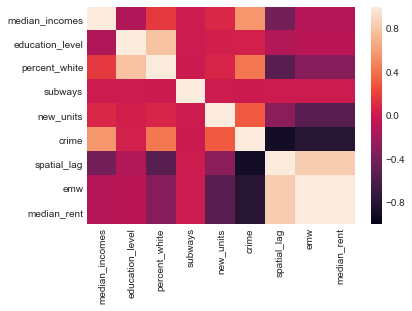

In [284]:
sns.heatmap(Cs.mean(axis=2), xticklabels = feature_labels+['median_rent'], yticklabels = feature_labels + ['median_rent'], vmin = -1, vmax =1)
plt.show()

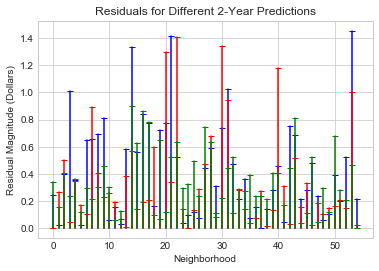

In [186]:
fig, ax = plt.subplots()
ax.stem(range(k),np.abs(residslin1), markerfmt='b_', linefmt='b', basefmt=' ')
ax.stem(range(k),np.abs(residslin2), markerfmt='r_', linefmt='r', basefmt=' ')
ax.stem(range(k),np.abs(residsexp), markerfmt='g_', linefmt='g', basefmt= ' ')
plt.title('Residuals for Different 2-Year Predictions')
plt.xlabel('Neighborhood')
plt.ylabel('Residual Magnitude (Dollars)')
plt.show()

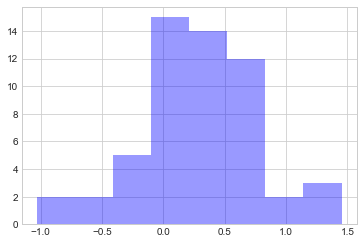

In [289]:
sns.distplot(residslin1, kde=False, color = 'b')
plt.show()

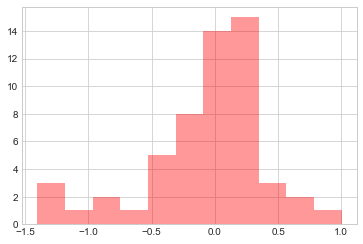

In [183]:
sns.distplot(residslin2, kde=False, color = 'r')
plt.show()

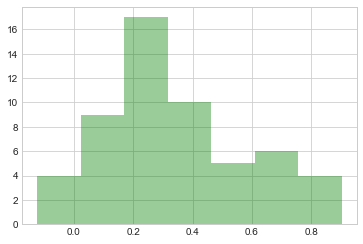

In [188]:
sns.distplot(residsexp, kde=False, color = 'g')
plt.show()

In [308]:
residstree = np.zeros(k)
for i in range(k):
    regr = tree.DecisionTreeRegressor()
    regr.fit(X_train[i], Y_train[i])
    rvals[i] = regr.score(X[i],Y[i])
    residstree[i] = Y_test[i,1] - regr.predict(X_test[i,1].reshape(1, -1))

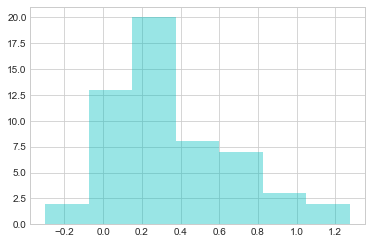

In [309]:
sns.distplot(residstree, kde=False, color = 'c')
plt.show()

In [314]:
residsfrst = np.zeros(k)
for i in range(k):
    regr = RandomForestRegressor()
    regr.fit(X_train[i], Y_train[i])
    rvals[i] = regr.score(X_test[i],Y_test[i])
    residsfrst[i] = Y_test[i,1] - regr.predict(X_test[i,1].reshape(1, -1))

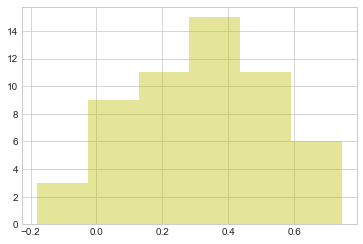

In [315]:
sns.distplot(residsfrst, kde=False, color = 'y')
plt.show()

In [376]:
focus = pd.DataFrame(X[20], columns = feature_labels)
focus = focus.drop('subways', axis = 1)

In [378]:
focus_obs = pd.DataFrame(Y[20], columns = ['median_rent'])

In [379]:
focus = pd.concat([focus, focus_obs.shift(-1)], axis=1)

In [380]:
focus.dropna(how='any')

,median_incomes,education_level,percent_white,new_units,crime,spatial_lag,emw,median_rent
0,0.450969,-0.455558,0.265182,0.878548,0.269558,0.051779,0.018444,-0.208810
1,0.370646,-0.315776,0.045409,0.149329,0.269558,0.051779,0.053149,0.112436
2,0.047450,-0.142114,0.012686,0.018000,0.296254,0.184927,0.136223,0.112436
3,0.543651,-0.274575,0.051306,-0.104688,0.438634,-0.258897,0.136172,0.497932
4,-0.208731,-0.390759,0.220166,-0.256753,-0.113088,0.184927,-0.217780,0.497932
5,-0.031924,0.108331,-0.013153,-0.244657,-0.126436,-0.303280,-0.019023,-0.273059
6,-0.166905,0.214345,0.033187,-0.073584,0.140526,-0.214515,-0.271555,0.048187
7,-0.209681,0.088159,0.031509,-0.118513,-0.001854,-0.480809,-0.295531,-0.016062
8,-0.125555,0.265800,-0.917809,0.097488,-0.104189,0.318074,-0.247925,-0.144561
9,-0.297610,0.323171,0.038503,-0.123697,-0.166481,-0.303280,-0.354175,-0.530056


In [407]:
test = focus[train_features].iloc[10]

In [408]:
test_X = test.values
test_X

array([-0.37508169,  0.15472142,  0.15574972, -0.11160051, -0.25101877,
        0.40683857,  0.52681228])

In [409]:
train = focus.iloc[:10]

In [384]:
train

,median_incomes,education_level,percent_white,new_units,crime,spatial_lag,emw,median_rent
0,0.450969,-0.455558,0.265182,0.878548,0.269558,0.051779,0.018444,-0.208810
1,0.370646,-0.315776,0.045409,0.149329,0.269558,0.051779,0.053149,0.112436
2,0.047450,-0.142114,0.012686,0.018000,0.296254,0.184927,0.136223,0.112436
3,0.543651,-0.274575,0.051306,-0.104688,0.438634,-0.258897,0.136172,0.497932
4,-0.208731,-0.390759,0.220166,-0.256753,-0.113088,0.184927,-0.217780,0.497932
5,-0.031924,0.108331,-0.013153,-0.244657,-0.126436,-0.303280,-0.019023,-0.273059
6,-0.166905,0.214345,0.033187,-0.073584,0.140526,-0.214515,-0.271555,0.048187
7,-0.209681,0.088159,0.031509,-0.118513,-0.001854,-0.480809,-0.295531,-0.016062
8,-0.125555,0.265800,-0.917809,0.097488,-0.104189,0.318074,-0.247925,-0.144561
9,-0.297610,0.323171,0.038503,-0.123697,-0.166481,-0.303280,-0.354175,-0.530056


In [386]:
train_features = ['median_incomes', 'education_level', 'percent_white', 'new_units',
       'crime', 'spatial_lag', 'emw']

In [417]:
train_X = train[train_features].values
train_X = train_X.reshape(train_X.shape[0], 1, train_X.shape[1])

In [418]:
train_Y = train['median_rent'].values

In [423]:
train_Y = train_Y.reshape(10,1)

In [447]:
test_Y = Y[20,10]

In [444]:
n_batch = 1
n_epoch = 1000
n_neurons = 10
model = Sequential()
model.add(LSTM(n_neurons, batch_input_shape=(n_batch, train_X.shape[1], train_X.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

In [445]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (1, 10)                   720       
_________________________________________________________________
dense_11 (Dense)             (1, 1)                    11        
Total params: 731
Trainable params: 731
Non-trainable params: 0
_________________________________________________________________


In [446]:
for i in range(n_epoch):
    model.fit(train_X, train_Y, epochs=1, batch_size=n_batch)
    model.reset_states()

Epoch 1/1
10/10 [==============================] - 1s 106ms/step - loss: 0.0985
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 0.0969
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 0.0995
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.1013
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 0.1059
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 0.0893
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0979
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 0.0912
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0932
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 0.0969
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 0.0924
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0907
Epoch 1/1
10/10 [==============================] - 0s 3ms/step

10/10 [==============================] - 0s 3ms/step - loss: 0.0837
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0887
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 0.0542
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0578
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0302
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0292
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0799
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0847
Epoch 1/1
10/10 [==============================] - 0s 5ms/step - loss: 0.0774
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0560
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0572
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0428
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0

10/10 [==============================] - 0s 4ms/step - loss: 0.0182
Epoch 1/1
10/10 [==============================] - 0s 5ms/step - loss: 0.0170
Epoch 1/1
10/10 [==============================] - 0s 5ms/step - loss: 0.0516
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0211
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0253
Epoch 1/1
10/10 [==============================] - 0s 5ms/step - loss: 0.0364
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0255
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0247
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0273
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0349
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0303
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0347
Epoch 1/1
10/10 [==============================] - 0s 5ms/step - loss: 0.0

10/10 [==============================] - 0s 5ms/step - loss: 0.0085
Epoch 1/1
10/10 [==============================] - 0s 5ms/step - loss: 0.0118
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 0.0189
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 0.0165
Epoch 1/1
10/10 [==============================] - 0s 5ms/step - loss: 0.0197
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0208
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0233
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0121
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0274
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0129
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0125
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0112
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0

10/10 [==============================] - 0s 3ms/step - loss: 0.0179
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 0.0154
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 0.0178
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 0.0200
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 0.0138
Epoch 1/1
10/10 [==============================] - 0s 5ms/step - loss: 0.0055
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 0.0169
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 0.0197
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0117
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 0.0187
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0082
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 0.0094
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 0.0

10/10 [==============================] - 0s 4ms/step - loss: 0.0069
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 0.0094
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0159
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0096
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0126
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 0.0149
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 0.0143
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0

10/10 [==============================] - 0s 4ms/step - loss: 0.0082
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0069
Epoch 1/1
10/10 [==============================] - ETA: 0s - loss: 0.005 - 0s 4ms/step - loss: 0.0081
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0072
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0039
Epoch 1/1
10/10 [==============================] - ETA: 0s - loss: 1.4341e-0 - 0s 5ms/step - loss: 0.0122
Epoch 1/1
10/10 [==============================] - 0s 7ms/step - loss: 0.0067
Epoch 1/1
10/10 [==============================] - 0s 6ms/step - loss: 0.0070
Epoch 1/1
10/10 [==============================] - 0s 5ms/step - loss: 0.0183
Epoch 1/1
10/10 [==============================] - 0s 5ms/step - loss: 0.0062
Epoch 1/1
10/10 [==============================] - 0s 5ms/step - loss: 0.0108
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0059
Epoch 1/1
10/10 [=====

10/10 [==============================] - 0s 6ms/step - loss: 0.0058
Epoch 1/1
10/10 [==============================] - 0s 5ms/step - loss: 0.0043
Epoch 1/1
10/10 [==============================] - 0s 5ms/step - loss: 0.0074
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0075
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0115
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0049
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0122
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0077
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0049
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0

10/10 [==============================] - 0s 3ms/step - loss: 0.0083
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0041
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0106
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 0.0078
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 0.0022
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 1/1
10/10 [==============================] - 0s 5ms/step - loss: 0.0092
Epoch 1/1
10/10 [==============================] - 0s 5ms/step - loss: 0.0135
Epoch 1/1
10/10 [==============================] - 0s 5ms/step - loss: 0.0103
Epoch 1/1
10/10 [==============================] - 0s 5ms/step - loss: 0.0108
Epoch 1/1
10/10 [==============================] - 0s 5ms/step - loss: 0.0

10/10 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0028
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0054
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 0.0090
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0049
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0031
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0041
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0028
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0042
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0026
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0064
Epoch 1/1
10/10 [==============================] - 0s 4ms/step - loss: 0.0

In [450]:
test_X = test_X.reshape(1,1,7)
yhat = model.predict(test_X, batch_size = 1)
print('>Expected=%.1f, Predicted=%.1f' %(test_Y, yhat))

>Expected=-0.5, Predicted=-0.6


In [38]:
n = 10 # number of years
m = 8 # number of features
k = 55 # number of PUMAs
years_ints = np.array(years).astype('int')
test_years = years_ints[0:n]
points_per_year = 12
X_interpolated = si.interpolate.interp1d(test_years,X,axis=1,kind='linear')
Y_interpolated = si.interpolate.interp1d(test_years,Y,axis=1,kind='linear')
ts = np.linspace(test_years[0], test_years[-1],n*points_per_year)

In [39]:
Y_interpolated(ts).shape

(55, 120)

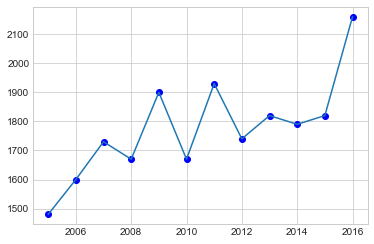

In [195]:
y = median_rents[years].iloc[15].transpose().values
xs = np.array(map(int, years))
ax = plt.plot(yearsnum,y, 'bo')
f = si.interpolate.interp1d(yearsnum,y,kind='linear')
xnew = np.arange(yearsnum[0], yearsnum[-1] + 0.1, 0.1)
ynew = f(xnew)
plt.plot(xnew, ynew)
plt.show()

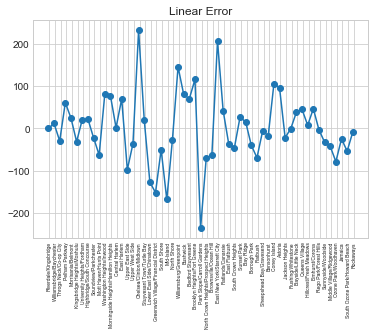

In [61]:
sns.set_style('whitegrid')
N = 55
fig, ax = plt.subplots()
width = 0.35
ind = np.arange(N)
ax.set_title('Rents Actual vs Predicted')
ax.set_xticks(ind + width / 2)
errs = predictions - Y_test
p1 = ax.plot(errs, 'o-')
ax.set_title('Linear Error')
ax.set_xticklabels(median_rents['Sub-Borough Area'], rotation='vertical', fontsize = 5)
ax.yaxis.set_label("Monthly Rent (Dollars)")
plt.show()

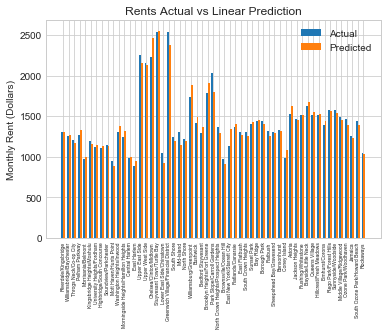

In [62]:
sns.set_style("whitegrid")
N = 55
fig, ax = plt.subplots()
width = 0.35
ind = np.arange(N)
p1 = ax.bar(ind, Y_test, width, bottom=0)
p2 = ax.bar(ind + width, predictions, width, bottom=0)
ax.set_title('Rents Actual vs Linear Prediction')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(median_rents['Sub-Borough Area'], rotation='vertical', fontsize = 5)
ax.legend((p1[0], p2[0]), ('Actual', 'Predicted'))
plt.ylabel("Monthly Rent (Dollars)")
plt.show()

In [54]:
colors = sns.cubehelix_palette(8)
colors

[[0.9312692223325372, 0.8201921796082118, 0.7971480974663592],
 [0.8822898168737189, 0.695820866705742, 0.7065457119485431],
 [0.8135380254700676, 0.5705055182357822, 0.639280859468155],
 [0.7195800708349119, 0.45537982893127477, 0.5861062995810926],
 [0.6046906802634469, 0.35739308184976665, 0.5337407853692406],
 [0.46496993672552045, 0.26868986121314253, 0.4636527763640647],
 [0.3210194743259347, 0.19303051265196464, 0.3707881677724792],
 [0.1750865648952205, 0.11840023306916837, 0.24215989137836502]]

In [21]:
row = neighbor_means.loc[3702]
plt.plot(years, row[years], color = colors[5])
plt.xlabel('Year')
plt.ylabel('Rent (Dollars)')
plt.title('Mean Rent of Adjacent Neighborhoods')
plt.show()

NameError: name 'neighbor_means' is not defined

$$x_i = \frac{1}{N_i}\sum_{j \in n(i)} x_j $$

In [22]:
$$\frac{N}{W}\frac{}{}

SyntaxError: invalid syntax (<ipython-input-22-a3695cb7cbd7>, line 1)